In [229]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
import catboost as cb
from sklearn.model_selection import GridSearchCV
import shap
shap.initjs()

### 1. Считать в pandas.DataFrame любой источник данных: CSV, JSON, Excel-файл, HTML-таблицу и т.п.

In [63]:
df = pd.read_csv('../datasets/Score.csv')
df

,Delay_from_due_date,Num_of_Delayed_Payment,Num_Credit_Inquiries,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Amount_invested_monthly,Monthly_Balance,Credit_Score,Credit_Mix,...,Age,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Monthly_Inhand_Salary,Changed_Credit_Limit,Outstanding_Debt,Total_EMI_per_month
0,3.0,7.0,4.0,26.822620,265.0,No,80.415295,312.494089,Good,Good,...,23.0,19114.12,3.0,4.0,3.0,4.0,1824.843333,11.27,809.98,49.574949
1,3.0,7.0,4.0,31.944960,265.0,No,118.280222,284.629162,Good,Good,...,23.0,19114.12,3.0,4.0,3.0,4.0,1824.843333,11.27,809.98,49.574949
2,3.0,7.0,4.0,28.609352,267.0,No,81.699521,331.209863,Good,Good,...,23.0,19114.12,3.0,4.0,3.0,4.0,1824.843333,11.27,809.98,49.574949
3,5.0,4.0,4.0,31.377862,268.0,No,199.458074,223.451310,Good,Good,...,23.0,19114.12,3.0,4.0,3.0,4.0,1824.843333,11.27,809.98,49.574949
4,6.0,4.0,4.0,24.797347,269.0,No,41.420153,341.489231,Good,Good,...,23.0,19114.12,3.0,4.0,3.0,4.0,1824.843333,11.27,809.98,49.574949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87949,23.0,7.0,3.0,34.663572,378.0,No,60.971333,479.866228,Poor,Good,...,25.0,39628.99,4.0,6.0,7.0,2.0,3359.415833,11.50,502.38,35.104023
87950,18.0,7.0,3.0,40.565631,379.0,No,54.185950,496.651610,Poor,Good,...,25.0,39628.99,4.0,6.0,7.0,2.0,3359.415833,11.50,502.38,35.104023
87951,27.0,6.0,3.0,41.255522,380.0,No,24.028477,516.809083,Poor,Good,...,25.0,39628.99,4.0,6.0,7.0,2.0,3359.415833,11.50,502.38,35.104023
87952,20.0,6.0,3.0,33.638208,381.0,No,251.672582,319.164979,Standard,Good,...,25.0,39628.99,4.0,6.0,7.0,2.0,3359.415833,11.50,502.38,35.104023


### 2. Датасет и подготовка данных:

Привести описание датасета.

Данный датасет содержит информацию о кредитной истории и финансовом поведении клиентов. Он включает в себя различные признаки, связанные с кредитными платежами, задолженностями, кредитным рейтингом и демографическими данными.
| Признак                  | Описание                                                    | Тип данных     |
|--------------------------|-------------------------------------------------------------|----------------|
| Delay_from_due_date      | Количество дней задержки платежа от установленного срока    | float          |
| Num_of_Delayed_Payment   | Общее количество просроченных платежей у клиента            | float          |
| Num_Credit_Inquiries     | Количество запросов в кредитную историю за последний период | float          |
| Credit_Utilization_Ratio | Процент использования доступного кредитного лимита          | float          |
| Credit_History_Age       | Возраст кредитной истории в месяцах                         | float          |
| Payment_of_Min_Amount    | Привычка клиента оплачивать только минимальный платёж       | Категориальный |
| Amount_invested_monthly  | Сумма, которую клиент регулярно инвестирует                 | float          |
| Monthly_Balance          | Среднемесячный остаток средств на счетах                    | float          |
| Credit_Score             | Кредитный рейтинг                                           | Категориальный |
| Credit_Mix               | Тип кредитного портфеля                                     | Категориальный |
| Payment_Behaviour        | Шаблон поведения при платежах                               | Категориальный |
| Age                      | Возраст клиента                                             | float          |
| Annual_Income            | Годовой доход в денежных единицах                           | float          |
| Num_Bank_Accounts        | Количество открытых банковских счетов                       | float          |
| Num_Credit_Card          | Количество имеющихся кредитных карт                         | float          |
| Interest_Rate            | Процентная ставка по основному кредиту                      | float          |
| Num_of_Loan              | Количество активных кредитов                                | float          |
| Monthly_Inhand_Salary    | Чистая ежемесячная зарплата                                 | float          |
| Changed_Credit_Limit     | Изменение кредитного лимита за последний период             | float          |
| Outstanding_Debt         | Текущая сумма непогашенного долга                           | float          |
| Total_EMI_per_month      | Общая сумма ежемесячных платежей по кредитам                | float          |

Target-переменная: Credit_Score (категориальная, но для регрессии можно преобразовать в числовые значения)

Осуществить предобработку данных (избавиться от null, убрать некоторые признаки и т.п.) - "подчистить данные".

In [64]:
df = df.dropna()
cat_features = df.select_dtypes(include=['object']).columns.tolist()
quant_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'Credit_Score' in quant_features:
    quant_features.remove('Credit_Score')
le = LabelEncoder()
df['Credit_Score'] = le.fit_transform(df['Credit_Score'])
target = 'Credit_Score'

Нормализовать численные данные.

In [65]:
scaler = StandardScaler()
df[quant_features] = scaler.fit_transform(df[quant_features])

Разбить выборку на обучающую и тестовую.

In [66]:
# 1. С закодированными категориальными признаками
data_encoded = df.copy()
for col in cat_features:
    data_encoded[col] = LabelEncoder().fit_transform(df[col])

# 2. С категориальными признаками "как есть"
data_raw_cat = df.copy()

# Разделение на обучающую и тестовую выборки
X_encoded = data_encoded.drop(target, axis=1)
y = data_encoded[target]
X_raw_cat = data_raw_cat.drop(target, axis=1)

X_train_enc, X_test_enc, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
X_train_raw, X_test_raw, _, _ = train_test_split(X_raw_cat, y, test_size=0.2, random_state=42)

### 3. Для каждого из классификаторов (*AdaBoost*, *GradientBoostingClassifier*, *XGBoost*, *CatBoost*)

С использованием GridSearchCV/grid_search осуществить подбор гиперпараметра модели, использовать выборки с закодированными категориальными признаками.

Вывести метрики на тестовом наборе (как минимум classification_report, другие по желанию).

#### AdaBoost

In [67]:
ada = AdaBoostClassifier()
params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}
ada_gs = GridSearchCV(ada, params, cv=3, n_jobs=-1)
ada_gs.fit(X_train_enc, y_train)
best_ada = ada_gs.best_estimator_
y_pred = best_ada.predict(X_test_enc)
print("AdaBoost")
print(classification_report(y_test, y_pred))

AdaBoost
              precision    recall  f1-score   support

           0       0.57      0.61      0.59      3099
           1       0.66      0.58      0.61      5084
           2       0.69      0.72      0.71      9408

    accuracy                           0.66     17591
   macro avg       0.64      0.64      0.64     17591
weighted avg       0.66      0.66      0.66     17591



#### GradientBoostingClassifier

In [69]:
gb = GradientBoostingClassifier()
params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5]
}
gb_gs = GridSearchCV(gb, params, cv=3, n_jobs=-1)
gb_gs.fit(X_train_enc, y_train)
best_gb = gb_gs.best_estimator_
y_pred = best_gb.predict(X_test_enc)
print("GradientBoosting")
print(classification_report(y_test, y_pred))

GradientBoosting
              precision    recall  f1-score   support

           0       0.66      0.73      0.69      3099
           1       0.76      0.72      0.74      5084
           2       0.79      0.79      0.79      9408

    accuracy                           0.76     17591
   macro avg       0.74      0.74      0.74     17591
weighted avg       0.76      0.76      0.76     17591



#### XGBoost (с закодированными признаками)

In [70]:
xgb_enc = xgb.XGBClassifier()
params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0, 0.1]
}
xgb_gs = GridSearchCV(xgb_enc, params, cv=3, n_jobs=-1)
xgb_gs.fit(X_train_enc, y_train)
best_xgb_enc = xgb_gs.best_estimator_
y_pred = best_xgb_enc.predict(X_test_enc)
print("XGBoost (encoded)")
print(classification_report(y_test, y_pred))

XGBoost (encoded)
              precision    recall  f1-score   support

           0       0.64      0.71      0.67      3099
           1       0.76      0.70      0.72      5084
           2       0.78      0.78      0.78      9408

    accuracy                           0.74     17591
   macro avg       0.72      0.73      0.73     17591
weighted avg       0.75      0.74      0.74     17591



#### XGBoost (с категориальными признаками "как есть")

In [73]:
for col in ['Payment_of_Min_Amount', 'Credit_Mix', 'Payment_Behaviour']:
    X_train_raw[col] = X_train_raw[col].astype('category')
    X_test_raw[col] = X_test_raw[col].astype('category')
    
best_xgb_raw = xgb.XGBClassifier(**xgb_gs.best_params_, enable_categorical=True)
best_xgb_raw.fit(X_train_raw, y_train)
y_pred = best_xgb_raw.predict(X_test_raw)
print("XGBoost (raw cat)")
print(classification_report(y_test, y_pred))

XGBoost (raw cat)
              precision    recall  f1-score   support

           0       0.64      0.71      0.67      3099
           1       0.75      0.69      0.72      5084
           2       0.78      0.78      0.78      9408

    accuracy                           0.74     17591
   macro avg       0.72      0.73      0.73     17591
weighted avg       0.75      0.74      0.74     17591



#### CatBoost (с закодированными признаками)

In [71]:
cb_enc = cb.CatBoostClassifier(verbose=0)
params = {
    'iterations': [100, 200],
    'learning_rate': [0.05, 0.1],
    'depth': [3, 5],
    'l2_leaf_reg': [1, 3]
}
cb_gs = GridSearchCV(cb_enc, params, cv=3, n_jobs=-1)
cb_gs.fit(X_train_enc, y_train)
best_cb_enc = cb_gs.best_estimator_
y_pred = best_cb_enc.predict(X_test_enc)
print("CatBoost (encoded)")
print(classification_report(y_test, y_pred))

CatBoost (encoded)
              precision    recall  f1-score   support

           0       0.59      0.70      0.64      3099
           1       0.74      0.67      0.70      5084
           2       0.77      0.76      0.76      9408

    accuracy                           0.72     17591
   macro avg       0.70      0.71      0.70     17591
weighted avg       0.73      0.72      0.72     17591



#### CatBoost (с категориальными признаками "как есть")

In [78]:
cat_features = [col for col in cat_features if col in X_train_raw.columns]

# Инициализация и обучение CatBoost
best_cb_raw = cb.CatBoostClassifier(
    **cb_gs.best_params_,
    cat_features=cat_features,
    verbose=0
)

best_cb_raw.fit(X_train_raw, y_train)
y_pred = best_cb_raw.predict(X_test_raw)
print("\nCatBoost (raw cat):")
print(classification_report(y_test, y_pred))


CatBoost (raw cat):
              precision    recall  f1-score   support

           0       0.59      0.70      0.64      3099
           1       0.74      0.66      0.70      5084
           2       0.76      0.76      0.76      9408

    accuracy                           0.72     17591
   macro avg       0.70      0.71      0.70     17591
weighted avg       0.73      0.72      0.72     17591



Сравнить модели, выбрать лучшую.

1. AdaBoost:
- Accuracy: 0.66
- Macro avg F1-score: 0.64
- Weighted avg F1-score: 0.66

2. GradientBoosting:
- Accuracy: 0.76
- Macro avg F1-score: 0.74
- Weighted avg F1-score: 0.76

3. XGBoost (encoded):
- Accuracy: 0.74
- Macro avg F1-score: 0.73
- Weighted avg F1-score: 0.74

4. XGBoost (raw cat):
- Accuracy: 0.74
- Macro avg F1-score: 0.73
- Weighted avg F1-score: 0.74

5. CatBoost (encoded):
- Accuracy: 0.72
- Macro avg F1-score: 0.70
- Weighted avg F1-score: 0.72

6. CatBoost (raw cat):
- Accuracy: 0.72
- Macro avg F1-score: 0.70
- Weighted avg F1-score: 0.72


Вывод:
Модель GradientBoosting показывает наилучшие результаты по всем метрикам: точность (accuracy) 0.76, средняя F1-оценка (macro avg) 0.74 и взвешенная F1-оценка (weighted avg) 0.76. Это делает её лучшей среди представленных моделей.

In [ ]:
# При попытке использовать SHAP для GradientBoosting, возникает ошибка 
# InvalidModelError: GradientBoostingClassifier is only supported for binary classification right now!
# Поэтому используем ближайшую по метрикам модель, XGBoost (encoded)
best_model  = best_xgb_enc


### 4. Важность признаков:

С использованием shap.TreeExplainer получить *SHAP* -значения для лучшей модели.

In [ ]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_enc)

Тип shap_values: <class 'numpy.ndarray'>
[ 0.02933041 -0.01807983  0.0243834 ]


Построить график shap.plots.force для одного объекта выборки и для среза произвольного размера.

In [114]:
feature_indices = [0, 1, 2]
shap.plots.force(
    explainer.expected_value[0],
    shap_values[0][0, feature_indices],
    X_test_enc.iloc[0, feature_indices]
)

Построить график shap.plots.bar для одного объекта выборки.

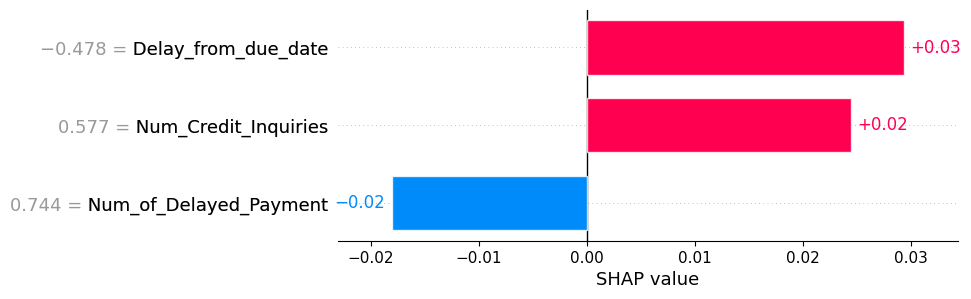

In [115]:
shap.plots.bar(shap.Explanation(values=shap_values[0][0,:], 
               base_values=explainer.expected_value[0], 
               data=X_test_raw.iloc[0,:]))

Построить график shap.plots.waterfall для одного объекта выборки.

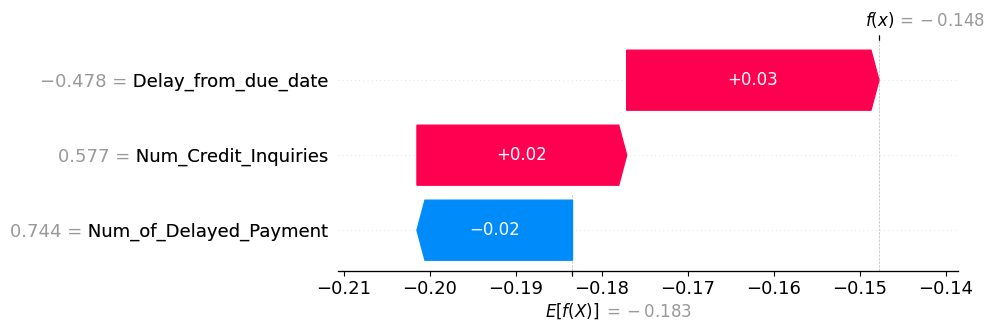

In [116]:
shap.plots.waterfall(shap.Explanation(values=shap_values[0][0,:], 
                     base_values=explainer.expected_value[0], 
                     data=X_test_raw.iloc[0,:]))

Построить 2 графика shap.plots.scatter для какого-нибудь признака. На одном раскрасить относительно себя, на втором – относительно другого признака.

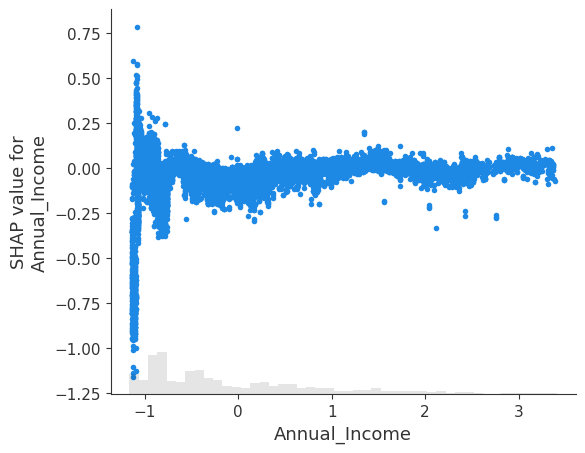

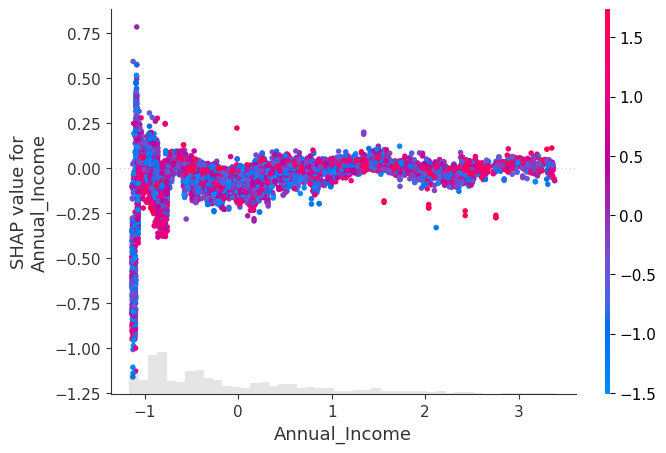

In [205]:
feature_names = X_test_enc.columns
annual_income_index = list(feature_names).index("Annual_Income")
age_index = list(feature_names).index("Age")

class_idx = 0
shap_values_single_class = shap_values[:, :, class_idx]

shap_explanation = shap.Explanation(
    values=shap_values_single_class,
    base_values=explainer.expected_value[class_idx],
    data=X_test_enc.values,
    feature_names=X_test_enc.columns.tolist()
)

shap.plots.scatter(shap_explanation[:, annual_income_index])

shap.plots.scatter(
    shap_explanation[:, annual_income_index],
    color=X_test_enc["Age"].values
)

Построить график shap.plots.beeswarm для всех признаков.

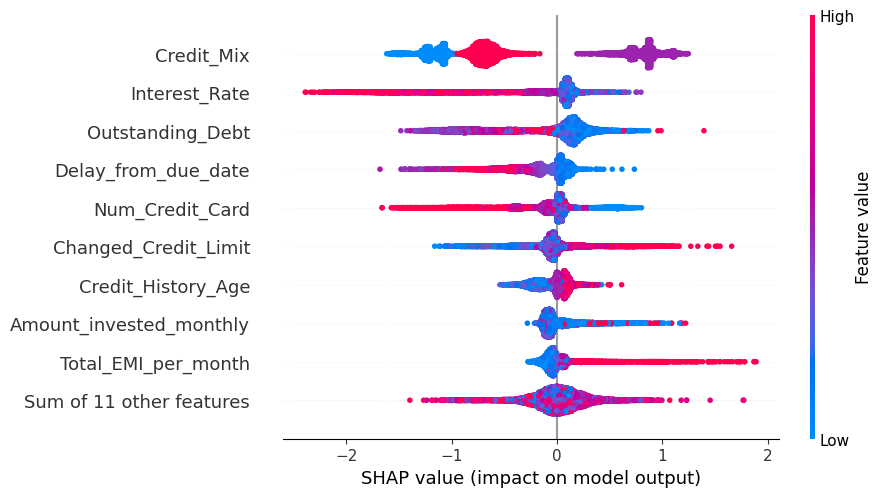

In [206]:
shap.plots.beeswarm(shap_explanation)

Построить график shap.plots.bar для всех признаков.

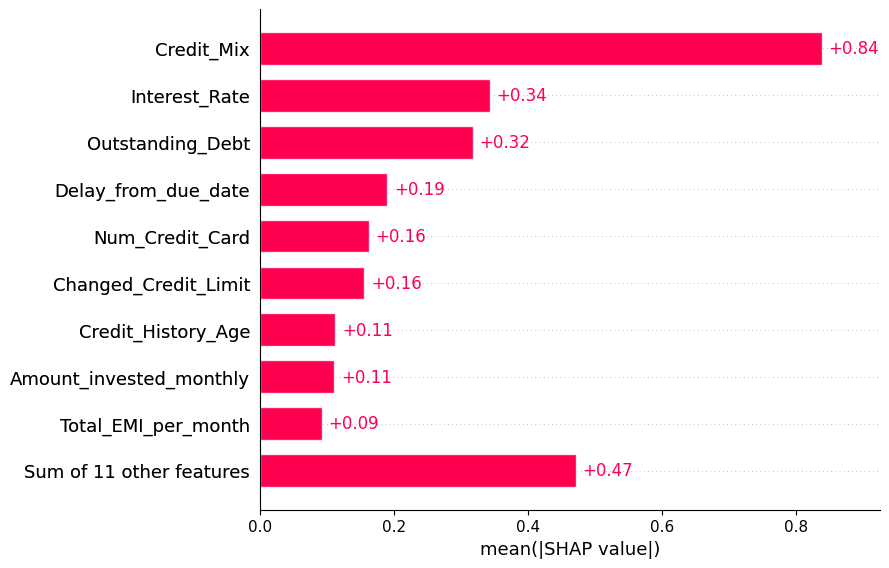

In [207]:
shap.plots.bar(shap_explanation)


На основании двух последних графиков и/или используя feature_importance отфильровать признаки (отразить сформулированные выводы в тексте), переобучить лучшую модель.

In [221]:
feature_importance = np.abs(shap_explanation.values).mean(axis=0)
important_features = X_test_raw.columns[feature_importance > np.quantile(feature_importance, 0.75)]
print(important_features)

Index(['Delay_from_due_date', 'Credit_Mix', 'Num_Credit_Card', 'Interest_Rate',
       'Outstanding_Debt'],
      dtype='object')


Топ-3 наиболее влиятельных признака:

- Credit_Mix (тип кредитного портфеля) - абсолютный лидер с SHAP-значением +0.84
- Interest_Rate (процентная ставка) - второй по значимости (+0.34)
- Outstanding_Debt (непогашенная задолженность) - третий важный фактор (+0.32)

Обоснование выбора:
- Все признаки имеют SHAP-значение выше 0.15
- Включают 4 из 5 наиболее значимых факторов
- Исключены маловлиятельные признаки (SHAP < 0.1)


In [222]:
X_train_filtered = X_train_enc[important_features]
X_test_filtered = X_test_enc[important_features]
    
# Переобучаем модель
best_xgb_enc.fit(X_train_filtered, y_train)
y_pred_filtered = best_xgb_enc.predict(X_test_filtered)

print("XGBoost с отобранными признаками")
print(classification_report(y_test, y_pred_filtered))

XGBoost с отобранными признаками
              precision    recall  f1-score   support

           0       0.59      0.67      0.63      3099
           1       0.69      0.71      0.70      5084
           2       0.77      0.73      0.75      9408

    accuracy                           0.71     17591
   macro avg       0.69      0.70      0.69     17591
weighted avg       0.72      0.71      0.71     17591



Сравнить метрики до и после фильтрации.


**Полная модель (20 признаков)**
Accuracy: 0.74
F1-score (weighted avg): 0.74
Class-wise F1:
- Class 0: 0.67
- Class 1: 0.72
- Class 2: 0.78

**Модель с отобранными признаками (6 признаков)**
Accuracy: 0.71 (-0.03)
F1-score (weighted avg): 0.71 (-0.03)
Class-wise F1:
- Class 0: 0.63 (-0.04)
- Class 1: 0.70 (-0.02)
- Class 2: 0.75 (-0.03)
**Выводы:**
1. Незначительное снижение качества:
- Accuracy уменьшился на 3% (с 0.74 до 0.71)
- Weighted F1-score снизился на 3 процентных пункта
- Наибольшее падение для Class 0 (-0.04 F1)
2. Компромисс между точностью и интерпретируемостью:
- Потеря точности минимальна (в пределах погрешности для многих бизнес-задач)
- Упрощение модели с 20 до 6 признаков улучшает:
    - Скорость предсказаний
    - Возможности объяснения решений
    - Устойчивость к переобучению

Визуализировать полученное дерево решений.


<Figure size 2000x1200 with 0 Axes>

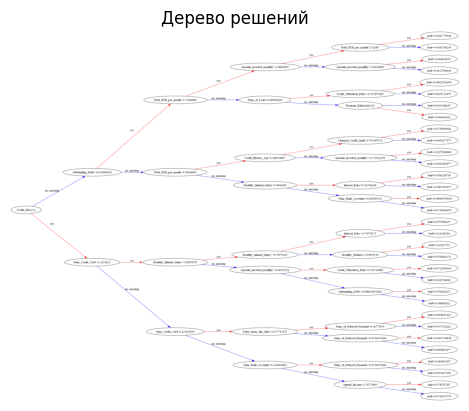

In [226]:
import matplotlib.pyplot as plt
from xgboost import plot_tree

plt.figure(figsize=(20, 12))
plot_tree(best_model, num_trees=0, rankdir='LR')
plt.title("Дерево решений")
plt.show()

### 5. Регрессия

С использованием GridSearchCV/grid_search осуществить подбор гиперпараметра модели линейной регрессии с использованием *XGBoost* или *CatBoost*.

In [260]:
target_reg = 'Annual_Income'
cat_features = df.select_dtypes(include=['object']).columns.tolist()
quant_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Удаляем целевую переменную из количественных признаков
if target_reg in quant_features:
    quant_features.remove(target_reg)

# Масштабирование количественных признаков
scaler = StandardScaler()
df[quant_features] = scaler.fit_transform(df[quant_features])

# 1. С закодированными категориальными признаками
data_encoded = df.copy()
for col in cat_features:
    data_encoded[col] = LabelEncoder().fit_transform(df[col])

# 2. С категориальными признаками "как есть" (не будем использовать для регрессии)
data_raw_cat = df.copy()

# Разделение данных
X_encoded = data_encoded.drop(target_reg, axis=1)
y = data_encoded[target_reg]  # Используем Annual_Income как целевую переменную

X_train_enc, X_test_enc, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

# Настройка и обучение XGBoost регрессора
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', verbosity=0)

# Параметры для GridSearch
params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0, 0.1]
}

xgb_gs = GridSearchCV(xgb_reg, params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
xgb_gs.fit(X_train_enc, y_train)

# Лучшая модель
best_xgb_reg = xgb_gs.best_estimator_


Вывести метрики *MSE*, *MAE* и *R2* на тестовом наборе.

In [262]:
y_pred = best_xgb_reg.predict(X_test_enc)

print("XGBoost Regression (До фильтрации)")
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"R²: {r2_score(y_test, y_pred)}")
print("Лучшие параметры:", xgb_gs.best_params_)

XGBoost Regression (До фильтрации)
MSE: 0.002015130109506787
MAE: 0.03664996868106404
R²: 0.9980155583415217
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 0.1}


Переобучить модель на отфильтрованном наборе признаков из пункта 4.

In [263]:
X_train_filtered = X_train_enc[important_features]
X_test_filtered = X_test_enc[important_features]

# 4. Переобучаем модель на отобранных признаках
best_xgb_reg.fit(X_train_filtered, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [264]:
y_pred_filtered = best_xgb_reg.predict(X_test_filtered)

print("XGBoost Regression (После фильтрации)")
print(f"MSE: {mean_squared_error(y_test, y_pred_filtered)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_filtered)}")
print(f"R²: {r2_score(y_test, y_pred_filtered)}")
print("Лучшие параметры:", xgb_gs.best_params_)

XGBoost Regression (После фильтрации)
MSE: 0.7483178993307479
MAE: 0.709117386485879
R²: 0.2630782468034374
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 0.1}


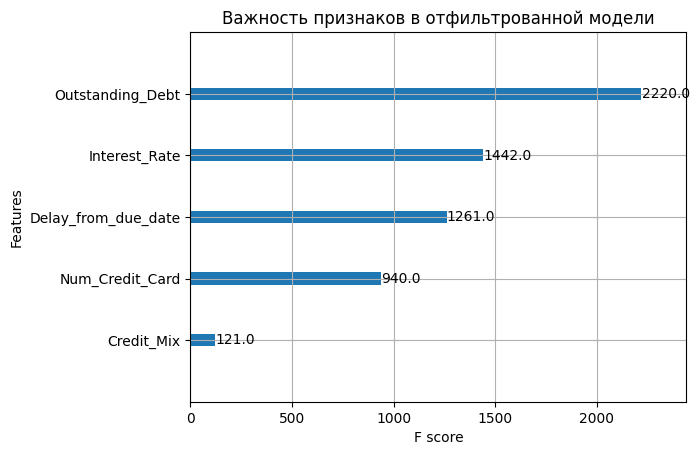

In [265]:
xgb.plot_importance(best_xgb_reg, importance_type='weight')
plt.title('Важность признаков в отфильтрованной модели')
plt.show()

Сравнить метрики до и после фильтрации.

После фильтрации признаков произошло катастрофическое падение качества модели:

1. MSE увеличилось в 371 раз (с 0.002 до 0.748)
2. R² упал с 0.998 до 0.263
3. MAE вырос в 19 раз
